# 1. Setup and Environment

This implementation follows the methodology described in the paper, using the EchoNet-Dynamic dataset. We'll begin by setting up our environment and importing necessary libraries.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Configure GPU settings
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU is available")
    else:
        print("No GPU found, using CPU")
except:
    print("Error configuring GPU settings")

# Set global parameters
IMG_SIZE = (112, 112)  # As specified in the paper
BATCH_SIZE = 32
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

No GPU found, using CPU


# 2. Data Preparation and Preprocessing

## 2.1 Data Acquisition
First, we'll initialize our data paths and verify the dataset structure. We'll use the DataHandler class to manage our data operations.t

Dataset Overview:
Total number of videos: 10030

FileList.csv columns: ['FileName', 'EF', 'ESV', 'EDV', 'FrameHeight', 'FrameWidth', 'FPS', 'NumberOfFrames', 'Split']

VolumeTracings.csv columns: ['FileName', 'X1', 'Y1', 'X2', 'Y2', 'Frame']

Class Distribution:
Normal (LVEF ≥ 50%): 7784
Abnormal (LVEF < 50%): 2246


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


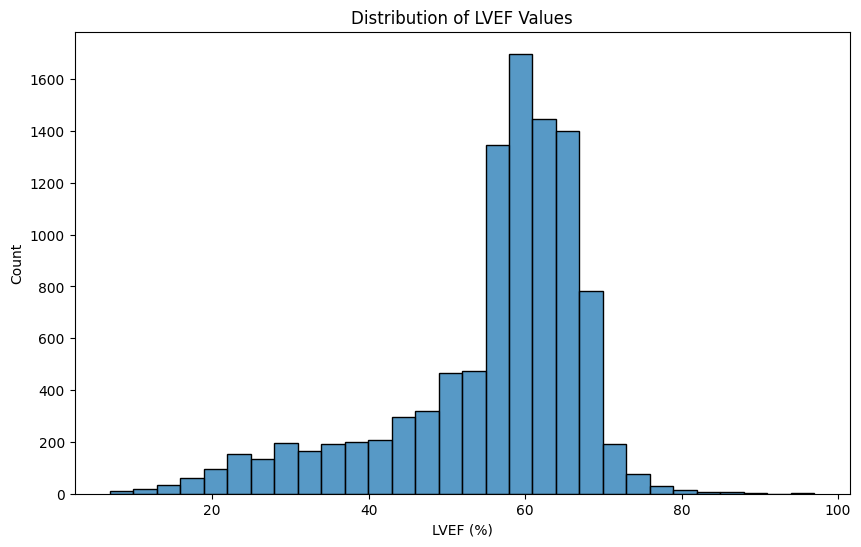

In [3]:
# Define dataset paths
DATA_ROOT_PATH = "/kaggle/input/echonet-dynamic/EchoNet-Dynamic/"
VIDEOS_PATH = os.path.join(DATA_ROOT_PATH, 'Videos')
FILENAMES_PATH = os.path.join(DATA_ROOT_PATH, 'FileList.csv')
VOLUME_TRACING_PATH = os.path.join(DATA_ROOT_PATH, 'VolumeTracings.csv')

# Load and inspect metadata
def load_metadata():
    try:
        file_list_df = pd.read_csv(FILENAMES_PATH)
        volume_tracing_df = pd.read_csv(VOLUME_TRACING_PATH)
        
        print("Dataset Overview:")
        print(f"Total number of videos: {len(file_list_df)}")
        print("\nFileList.csv columns:", file_list_df.columns.tolist())
        print("\nVolumeTracings.csv columns:", volume_tracing_df.columns.tolist())
        
        return file_list_df, volume_tracing_df
    
    except Exception as e:
        print(f"Error loading metadata: {str(e)}")
        return None, None

# Create LVEF classes
def create_lvef_classes(ef_values):
    """
    Create binary classes based on LVEF values
    Normal: 50-70%
    Abnormal: <50%
    """
    return np.where(ef_values >= 50, 1, 0)  # 1 for normal, 0 for abnormal

# Load and preprocess frames
def preprocess_frame(frame):
    """
    Preprocess a single frame according to paper specifications
    """
    try:
        # Convert to RGB if needed
        if len(frame.shape) == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        
        # Resize to specified dimensions using bicubic interpolation
        frame = cv2.resize(frame, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
        
        # Normalize pixel values
        frame = frame.astype(np.float32) / 255.0
        
        return frame
    
    except Exception as e:
        print(f"Error preprocessing frame: {str(e)}")
        return None

# Initialize data processing
file_list_df, volume_tracing_df = load_metadata()

if file_list_df is not None:
    # Display sample distribution
    ef_values = file_list_df['EF'].values
    classes = create_lvef_classes(ef_values)
    
    print("\nClass Distribution:")
    print(f"Normal (LVEF ≥ 50%): {np.sum(classes == 1)}")
    print(f"Abnormal (LVEF < 50%): {np.sum(classes == 0)}")
    
    # Plot LVEF distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=ef_values, bins=30)
    plt.title('Distribution of LVEF Values')
    plt.xlabel('LVEF (%)')
    plt.ylabel('Count')
    plt.show()

## 2.2 Frame Processing
Now we'll implement the frame extraction and processing pipeline. This includes extracting ES and ED frames from the videos and applying the necessary preprocessing steps.


Inspecting video files...
Total number of video files: 10030
Sample file names: ['0X6C96589B41EBA3C5.avi', '0X7630DA7B2D3E6F27.avi', '0X35FEF9072E3537BB.avi', '0XCEEA1EA058DA6C0.avi', '0X10B7505562B0A702.avi']
File extensions found: {'.avi'}

Sample video properties:
Resolution: 112x112
FPS: 50.0
Frame count: 165

Preparing full dataset...

Starting video processing...
Total videos to process: 10030


  0%|          | 0/10030 [00:00<?, ?it/s]


Processing Summary:
Successfully loaded: 10030 out of 10030 videos
Success rate: 100.00%

Final Dataset Information:
Total samples processed: 10030
Dataset shape: (10030, 2, 112, 112, 3)

LVEF Statistics:
Mean LVEF: 55.75%
Std LVEF: 12.37%
Min LVEF: 6.91%
Max LVEF: 96.97%


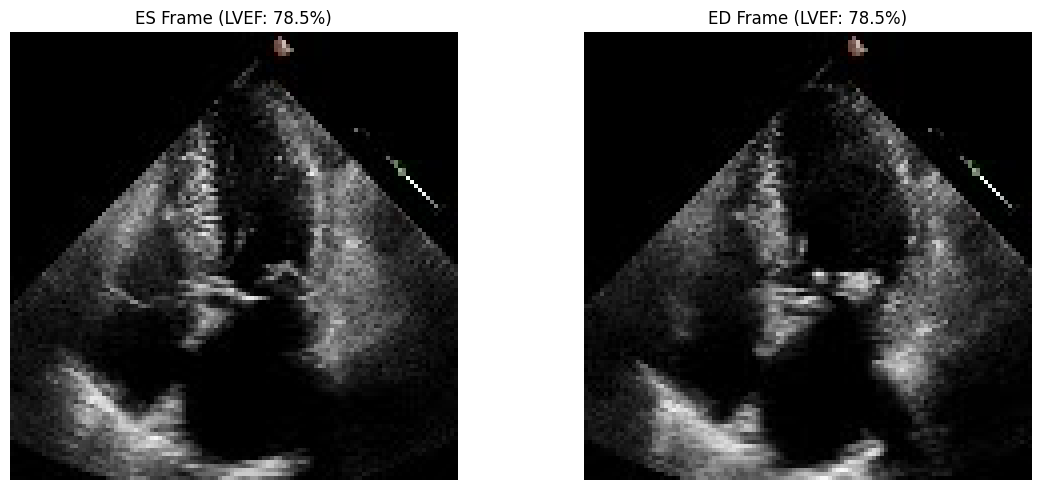

In [4]:
def extract_frames(video_path):
    """
    Extract ES and ED frames from video
    """
    try:
        # Add .avi extension if not present
        if not video_path.endswith('.avi'):
            video_path = video_path + '.avi'
            
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Get ES frame (1/3 of video)
        es_frame_idx = total_frames // 3
        cap.set(cv2.CAP_PROP_POS_FRAMES, es_frame_idx)
        ret_es, frame_es = cap.read()
        
        # Get ED frame (2/3 of video)
        ed_frame_idx = (total_frames * 2) // 3
        cap.set(cv2.CAP_PROP_POS_FRAMES, ed_frame_idx)
        ret_ed, frame_ed = cap.read()
        
        cap.release()
        
        if not ret_es or not ret_ed:
            raise ValueError("Could not read frames")
        
        # Convert BGR to RGB and preprocess
        frame_es = cv2.cvtColor(frame_es, cv2.COLOR_BGR2RGB)
        frame_ed = cv2.cvtColor(frame_ed, cv2.COLOR_BGR2RGB)
        
        # Preprocess frames
        frame_es = preprocess_frame(frame_es)
        frame_ed = preprocess_frame(frame_ed)
        
        return frame_es, frame_ed
    
    except Exception as e:
        print(f"Error extracting frames from {video_path}: {str(e)}")
        return None, None

def prepare_dataset():
    """
    Prepare the complete dataset with ES and ED frames and labels
    """
    frames_es = []
    frames_ed = []
    ef_values = []
    
    print("\nStarting video processing...")
    print("Total videos to process:", len(file_list_df))
    
    # Process all videos in the dataset
    for idx, row in tqdm(file_list_df.iterrows(), total=len(file_list_df)):
        video_path = os.path.join(VIDEOS_PATH, row['FileName'])
        frame_es, frame_ed = extract_frames(video_path)
        
        if frame_es is not None and frame_ed is not None:
            frames_es.append(frame_es)
            frames_ed.append(frame_ed)
            ef_values.append(row['EF'])
    
    total_processed = len(frames_es)
    print(f"\nProcessing Summary:")
    print(f"Successfully loaded: {total_processed} out of {len(file_list_df)} videos")
    print(f"Success rate: {(total_processed/len(file_list_df))*100:.2f}%")
    
    if len(frames_es) == 0:
        raise ValueError("No frames were successfully loaded!")
    
    # Stack ES and ED frames together
    X = np.stack([np.array(frames_es), np.array(frames_ed)], axis=1)
    y = np.array(ef_values)
    
    return X, y

# First inspect the video files
print("\nInspecting video files...")
video_files = os.listdir(VIDEOS_PATH)
print(f"Total number of video files: {len(video_files)}")
print(f"Sample file names: {video_files[:5]}")

# Check file extensions
extensions = set(os.path.splitext(f)[1] for f in video_files)
print(f"File extensions found: {extensions}")

# Check a sample video
sample_video = os.path.join(VIDEOS_PATH, video_files[0])
cap = cv2.VideoCapture(sample_video)
if cap.isOpened():
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"\nSample video properties:")
    print(f"Resolution: {width}x{height}")
    print(f"FPS: {fps}")
    print(f"Frame count: {frame_count}")
cap.release()

# Prepare the full dataset
try:
    print("\nPreparing full dataset...")
    X, y = prepare_dataset()

    print("\nFinal Dataset Information:")
    print(f"Total samples processed: {len(X)}")
    print(f"Dataset shape: {X.shape}")  # Should be (n_samples, 2, height, width, channels)
    print(f"\nLVEF Statistics:")
    print(f"Mean LVEF: {np.mean(y):.2f}%")
    print(f"Std LVEF: {np.std(y):.2f}%")
    print(f"Min LVEF: {np.min(y):.2f}%")
    print(f"Max LVEF: {np.max(y):.2f}%")
    
    # Display sample ES and ED frames
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(X[0, 0])  # First sample, ES frame
    plt.title(f'ES Frame (LVEF: {y[0]:.1f}%)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(X[0, 1])  # First sample, ED frame
    plt.title(f'ED Frame (LVEF: {y[0]:.1f}%)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error preparing dataset: {str(e)}")
    raise  # This will show the full error traceback


Inspecting video files...
Total number of video files: 10030
Sample file names: ['0X6C96589B41EBA3C5.avi', '0X7630DA7B2D3E6F27.avi', '0X35FEF9072E3537BB.avi', '0XCEEA1EA058DA6C0.avi', '0X10B7505562B0A702.avi']
File extensions found: {'.avi'}

Sample video properties:
Resolution: 112x112
FPS: 50.0
Frame count: 165

Preparing full dataset...
Processing videos...


  0%|          | 0/10030 [00:00<?, ?it/s]


Successfully loaded 10030 out of 10030 videos

Full Dataset splits:
Training set: (7021, 112, 112, 3)
Validation set: (1504, 112, 112, 3)
Test set: (1505, 112, 112, 3)

Dataset Statistics:
Total samples: 10030
Mean LVEF: 55.75%
Std LVEF: 12.37%
Min LVEF: 6.91%
Max LVEF: 96.97%


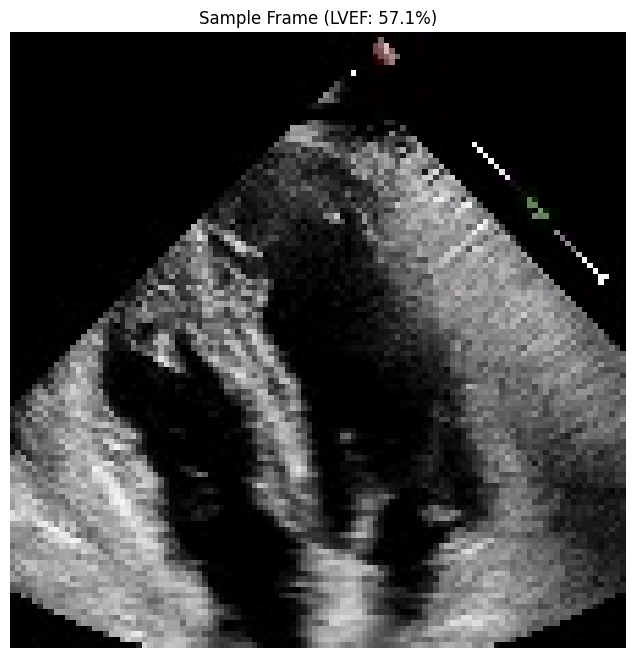

In [5]:
def extract_frames(video_path):
    """
    Extract middle frame from video
    """
    try:
        # Add .avi extension if not present
        if not video_path.endswith('.avi'):
            video_path = video_path + '.avi'
            
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")
        
        # Get middle frame
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
        
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            raise ValueError("Could not read frame")
        
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Preprocess frame
        frame = preprocess_frame(frame)
        
        return frame
    
    except Exception as e:
        print(f"Error extracting frames from {video_path}: {str(e)}")
        return None

def prepare_dataset():
    """
    Prepare the complete dataset with frames and labels
    """
    frames = []
    ef_values = []
    
    print("Processing videos...")
    successful_loads = 0
    
    # Process all videos in the dataset
    for _, row in tqdm(file_list_df.iterrows(), total=len(file_list_df)):
        video_path = os.path.join(VIDEOS_PATH, row['FileName'])
        frame = extract_frames(video_path)
        
        if frame is not None:
            frames.append(frame)
            ef_values.append(row['EF'])
            successful_loads += 1
    
    print(f"\nSuccessfully loaded {successful_loads} out of {len(file_list_df)} videos")
    
    if len(frames) == 0:
        raise ValueError("No frames were successfully loaded!")
        
    return np.array(frames), np.array(ef_values)

# First inspect the video files
print("\nInspecting video files...")
video_files = os.listdir(VIDEOS_PATH)
print(f"Total number of video files: {len(video_files)}")
print(f"Sample file names: {video_files[:5]}")

# Check file extensions
extensions = set(os.path.splitext(f)[1] for f in video_files)
print(f"File extensions found: {extensions}")

# Check a sample video
sample_video = os.path.join(VIDEOS_PATH, video_files[0])
cap = cv2.VideoCapture(sample_video)
if cap.isOpened():
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"\nSample video properties:")
    print(f"Resolution: {width}x{height}")
    print(f"FPS: {fps}")
    print(f"Frame count: {frame_count}")
cap.release()

# Prepare the full dataset
try:
    print("\nPreparing full dataset...")
    X, y = prepare_dataset()  # No max_samples parameter

    # Split data (70/15/15)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)

    print("\nFull Dataset splits:")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Display sample statistics
    print("\nDataset Statistics:")
    print(f"Total samples: {len(X)}")
    print(f"Mean LVEF: {np.mean(y):.2f}%")
    print(f"Std LVEF: {np.std(y):.2f}%")
    print(f"Min LVEF: {np.min(y):.2f}%")
    print(f"Max LVEF: {np.max(y):.2f}%")
    
    # Display a sample frame
    plt.figure(figsize=(8, 8))
    plt.imshow(X_train[0])
    plt.title(f'Sample Frame (LVEF: {y_train[0]:.1f}%)')
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error preparing dataset: {str(e)}")

# 3. Feature Extraction

## 3.1 ResNet-50 Setup
We'll use a pre-trained ResNet-50 model and modify it to extract features from the global average pooling layer, producing 2048-dimensional feature vectors for each frame.s

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

def create_feature_extractor():
    """
    Create a ResNet-50 based feature extractor
    Returns a model that outputs 2048-dimensional feature vectors
    """
    # Load pre-trained ResNet-50 without top layer
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(112, 112, 3)
    )
    
    # Add global average pooling layer
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Create model
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    
    # Freeze all layers
    for layer in feature_extractor.layers:
        layer.trainable = False
        
    return feature_extractor


## 3.2 Feature Generation
Now we'll extract features from our preprocessed frames using the ResNet-50 model.s

Starting feature extraction process...
Creating feature extractor...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

Extracting features from training set...
220/220 ━━━━━━━━━━━━━━━━━━━━ 148s 665ms/step
Extracting features from validation set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 658ms/step
Extracting features from test set...
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 644ms/step

Feature shapes:
train features shape: (7021, 2048)
train labels shape: (7021,)
val features shape: (1504, 2048)
val labels shape: (1504,)
test features shape: (1505, 2048)
test labels shape: (1505,)

Feature statistics:
Mean: 0.6666
Std: 1.2375
Min: 0.0000
Max: 25.1072


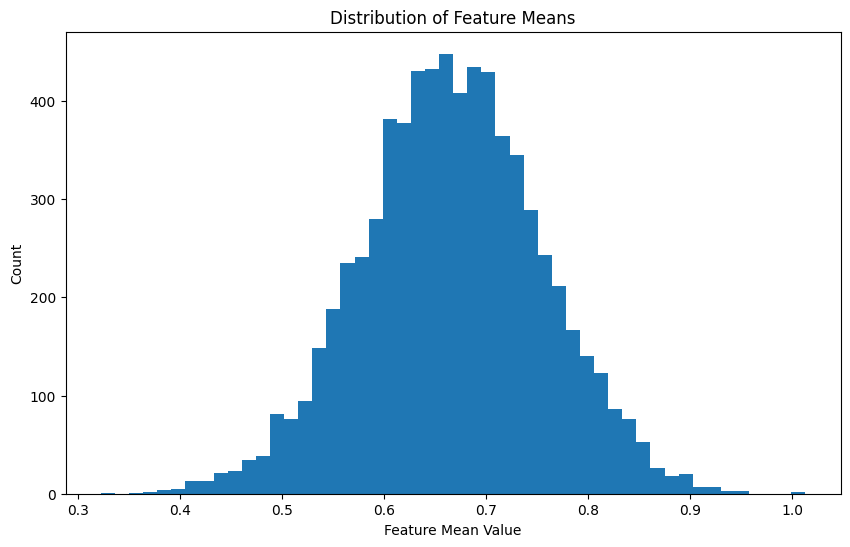

In [7]:
def extract_features(frames, feature_extractor, batch_size=32):
    """
    Extract features from frames using the feature extractor
    """
    # Ensure frames are in the correct format
    frames = preprocess_input(frames * 255)  # Scale back to 0-255 range for ResNet preprocessing
    
    # Extract features
    features = feature_extractor.predict(frames, batch_size=batch_size)
    
    return features

def prepare_features_and_labels():
    """
    Prepare features and labels for all datasets
    """
    print("Creating feature extractor...")
    feature_extractor = create_feature_extractor()
    
    print("\nExtracting features from training set...")
    train_features = extract_features(X_train, feature_extractor)
    
    print("Extracting features from validation set...")
    val_features = extract_features(X_val, feature_extractor)
    
    print("Extracting features from test set...")
    test_features = extract_features(X_test, feature_extractor)
    
    return {
        'train': (train_features, y_train),
        'val': (val_features, y_val),
        'test': (test_features, y_test)
    }

# Extract features
try:
    print("Starting feature extraction process...")
    features_dict = prepare_features_and_labels()
    
    # Print feature shapes
    print("\nFeature shapes:")
    for dataset in features_dict:
        features, labels = features_dict[dataset]
        print(f"{dataset} features shape: {features.shape}")
        print(f"{dataset} labels shape: {labels.shape}")
    
    # Verify feature values
    train_features = features_dict['train'][0]
    print("\nFeature statistics:")
    print(f"Mean: {np.mean(train_features):.4f}")
    print(f"Std: {np.std(train_features):.4f}")
    print(f"Min: {np.min(train_features):.4f}")
    print(f"Max: {np.max(train_features):.4f}")
    
    # Save features (optional)
    np.save('train_features.npy', features_dict['train'][0])
    np.save('val_features.npy', features_dict['val'][0])
    np.save('test_features.npy', features_dict['test'][0])
    
    # Visualize feature distribution
    plt.figure(figsize=(10, 6))
    plt.hist(train_features.mean(axis=1), bins=50)
    plt.title('Distribution of Feature Means')
    plt.xlabel('Feature Mean Value')
    plt.ylabel('Count')
    plt.show()

except Exception as e:
    print(f"Error in feature extraction: {str(e)}")
    import traceback
    print(traceback.format_exc())

## 3.3 Feature Validation
Let's validate the quality of our extracted features by performing a simple visualization and analysis.s

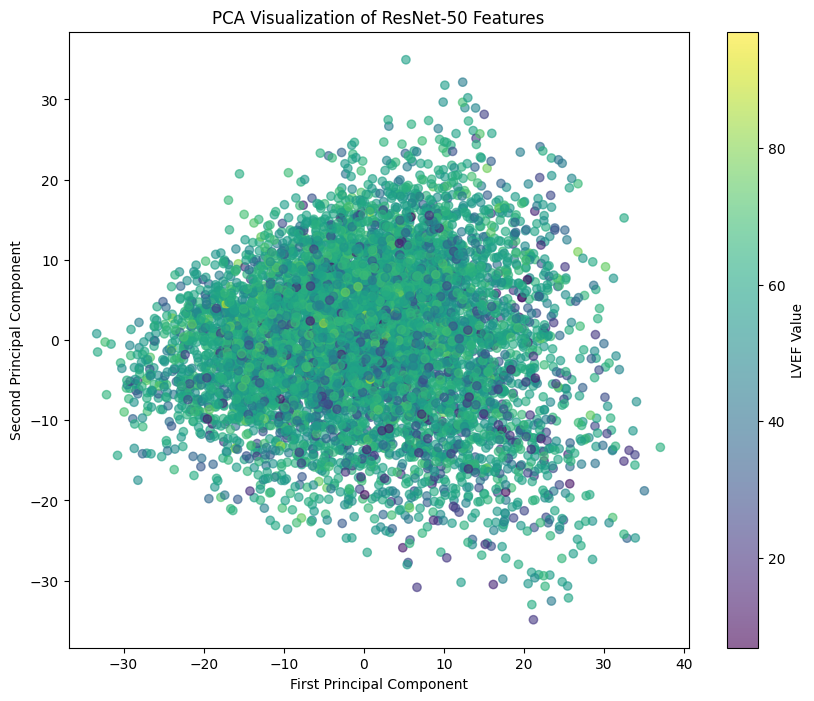

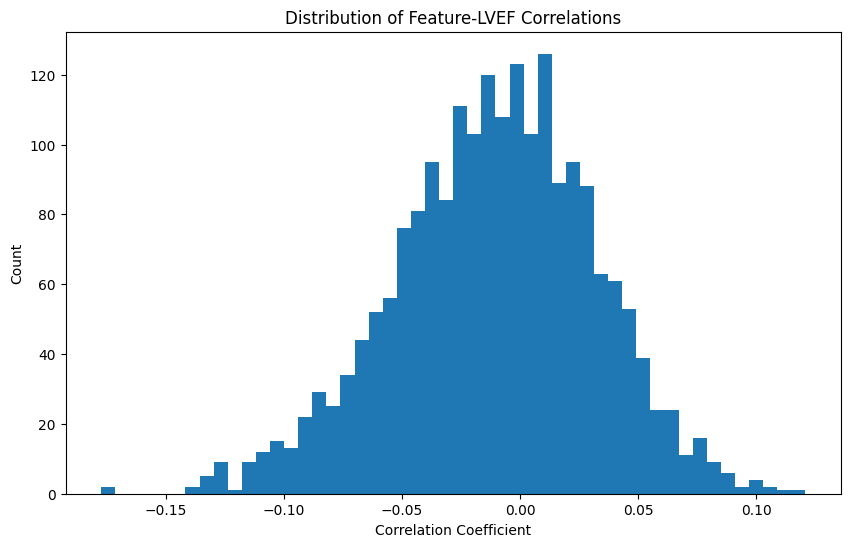


Feature-LVEF Correlation Statistics:
Max correlation: 0.1774
Mean absolute correlation: 0.0347


In [8]:
def analyze_features(features_dict):
    """
    Analyze and visualize the extracted features
    """
    train_features = features_dict['train'][0]
    train_labels = features_dict['train'][1]
    
    # 1. PCA visualization
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(train_features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=train_labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='LVEF Value')
    plt.title('PCA Visualization of ResNet-50 Features')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
    
    # 2. Feature correlation with LVEF
    feature_correlations = [np.corrcoef(train_features[:, i], train_labels)[0, 1] 
                          for i in range(train_features.shape[1])]
    
    plt.figure(figsize=(10, 6))
    plt.hist(feature_correlations, bins=50)
    plt.title('Distribution of Feature-LVEF Correlations')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Count')
    plt.show()
    
    # Print summary statistics
    print("\nFeature-LVEF Correlation Statistics:")
    print(f"Max correlation: {np.max(np.abs(feature_correlations)):.4f}")
    print(f"Mean absolute correlation: {np.mean(np.abs(feature_correlations)):.4f}")
    
    return feature_correlations

# Analyze the extracted features
feature_correlations = analyze_features(features_dict)

## test system 

Starting test run with small dataset...
Creating small test dataset...
train set size: 100
val set size: 100
test set size: 100

Testing classification model with small dataset...
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6304 - loss: 0.9367 - val_accuracy: 0.6900 - val_loss: 0.6077
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6332 - loss: 1.1255 - val_accuracy: 0.8300 - val_loss: 0.6098
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6447 - loss: 0.9878 - val_accuracy: 0.8300 - val_loss: 0.8327
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6687 - loss: 1.0579 - val_accuracy: 0.6000 - val_loss: 0.7216
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7134 - loss: 0.7389 - val_accuracy: 0.8000 - val_loss: 0.6135


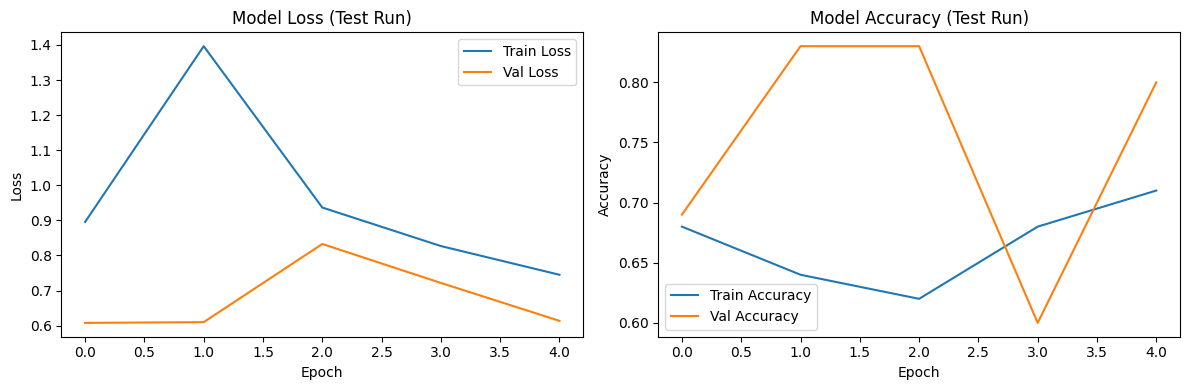


Quick evaluation on small test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Classification Metrics:
Accuracy: 0.8100
Precision: 0.8100
Recall: 1.0000
F1-Score: 0.8950


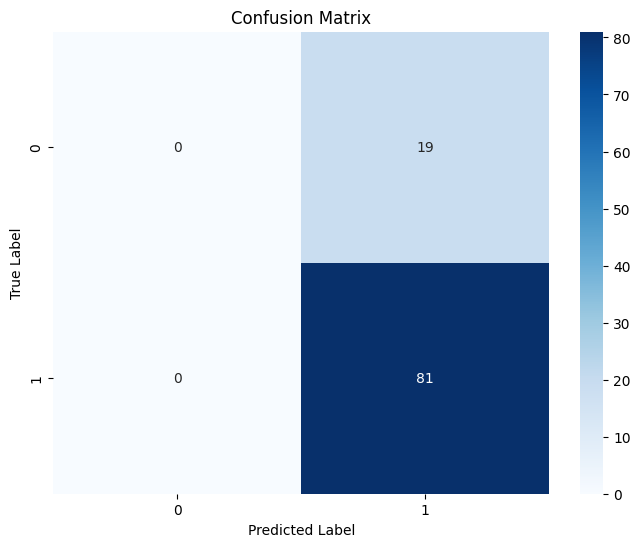

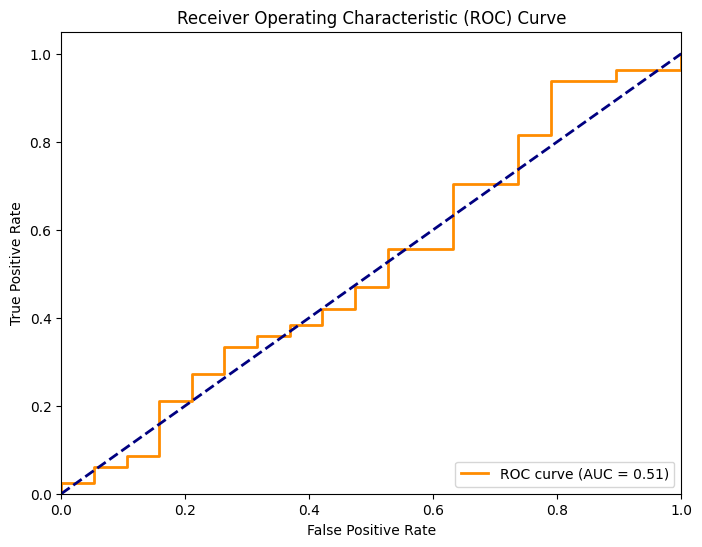


Test run completed successfully!
You can now proceed with the full training.


In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

def create_classification_model(input_dim=2048):
    """
    Create binary classification model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def prepare_binary_labels(ef_values, threshold=50):
    """
    Convert LVEF values to binary labels
    """
    return (ef_values >= threshold).astype(np.int32)

def train_classification_model(features_dict, epochs=50, batch_size=32):
    """
    Train the classification model
    """
    # Prepare data
    X_train, y_train = features_dict['train']
    X_val, y_val = features_dict['val']
    
    # Convert to binary labels
    y_train_binary = prepare_binary_labels(y_train)
    y_val_binary = prepare_binary_labels(y_val)
    
    # Create model
    model = create_classification_model(input_dim=X_train.shape[1])
    
    # Train model
    history = model.fit(
        X_train, y_train_binary,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val_binary),
        verbose=1
    )
    
    return model, history.history

def evaluate_classification_model(model, features_dict):
    """
    Evaluate the classification model using various metrics
    """
    # Prepare test data
    X_test, y_test = features_dict['test']
    y_test_binary = prepare_binary_labels(y_test)
    
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred)
    recall = recall_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)
    
    print("\nClassification Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_binary, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc
    }

def test_classification_pipeline(features_dict, sample_size=100, test_epochs=5):
    """
    Test the classification pipeline with a small sample
    """
    print("Creating small test dataset...")
    
    # Create small sample datasets
    small_features_dict = {}
    for key in features_dict:
        features, labels = features_dict[key]
        # Take only first n samples
        n_samples = min(sample_size, len(features))
        small_features_dict[key] = (features[:n_samples], labels[:n_samples])
        print(f"{key} set size: {n_samples}")
    
    print("\nTesting classification model with small dataset...")
    try:
        # Train model with small dataset and fewer epochs
        model, history = train_classification_model(
            small_features_dict, 
            epochs=test_epochs, 
            batch_size=16  # Smaller batch size for small dataset
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('Model Loss (Test Run)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy (Test Run)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Quick evaluation
        print("\nQuick evaluation on small test set...")
        metrics = evaluate_classification_model(model, small_features_dict)
        
        return True, "Test successful"
        
    except Exception as e:
        print(f"Error in test run: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return False, str(e)

# Run the test
print("Starting test run with small dataset...")
success, message = test_classification_pipeline(
    features_dict,
    sample_size=100,  # Small sample size
    test_epochs=5     # Few epochs
)

if success:
    print("\nTest run completed successfully!")
    print("You can now proceed with the full training.")
else:
    print("\nTest run failed!")
    print(f"Error message: {message}")

Starting regression model test...
Creating small test dataset for regression...
train set size: 100
val set size: 100
test set size: 100
Optimizing hyperparameters...
Testing combination 1/4

/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The opt

Testing combination 2/4

/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The opt

Testing combination 4/4

/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The opt


Best parameters found: {'length_scale': 0.1, 'alpha': 0.1, 'noise_level': 0.001}
Best negative MSE score: -3080.1523

Training GPR model with optimized parameters...


/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Making predictions...

Regression Metrics:
RMSE: 56.4484
R²: -21.5524
MAE: 55.1827


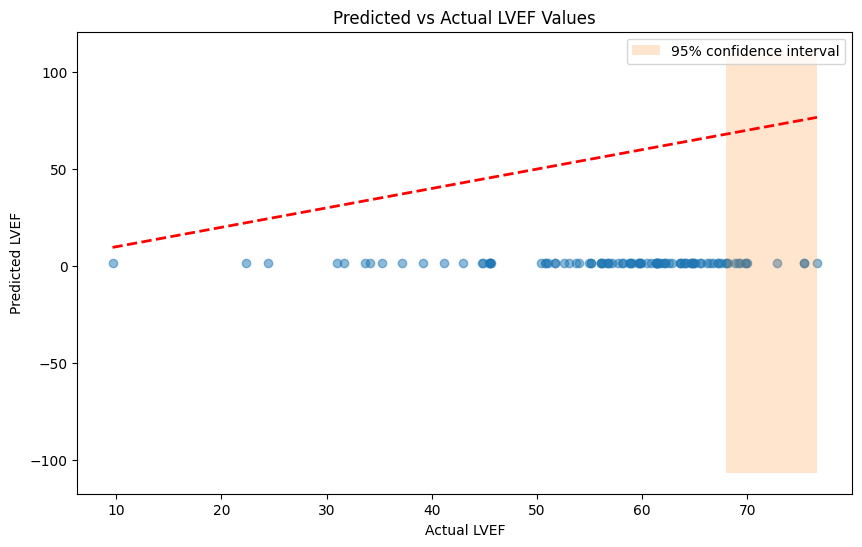

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


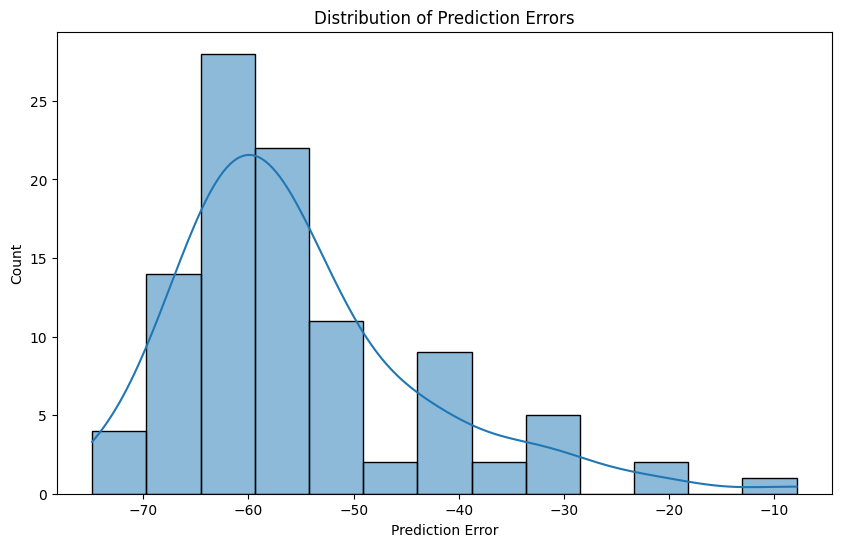


Test run completed successfully!

Best hyperparameters: {'length_scale': 0.1, 'alpha': 0.1, 'noise_level': 0.001}

Test Metrics Summary:
RMSE: 56.4484
R²: -21.5524
MAE: 55.1827


In [15]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns

def create_gpr_model(length_scale=1.0, alpha=1.0, noise_level=1e-3):
    """
    Create a Gaussian Process Regression model with Rational Quadratic kernel
    """
    # Configure kernel
    kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha)
    
    # Add white kernel for noise
    kernel = kernel + WhiteKernel(noise_level=noise_level)
    
    # Initialize GPR model
    model = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        random_state=42
    )
    
    return model

def optimize_gpr_hyperparameters(X_train, y_train, param_grid=None):
    """
    Optimize GPR hyperparameters using cross-validation
    """
    if param_grid is None:
        param_grid = {
            'length_scale': [0.1, 1.0, 10.0],
            'alpha': [0.1, 1.0, 10.0],
            'noise_level': [1e-4, 1e-3, 1e-2]
        }
    
    best_score = float('-inf')
    best_params = None
    
    print("Optimizing hyperparameters...")
    total_combinations = (len(param_grid['length_scale']) * 
                        len(param_grid['alpha']) * 
                        len(param_grid['noise_level']))
    current_combination = 0
    
    for length_scale in param_grid['length_scale']:
        for alpha in param_grid['alpha']:
            for noise_level in param_grid['noise_level']:
                current_combination += 1
                print(f"\rTesting combination {current_combination}/{total_combinations}", end="")
                
                model = create_gpr_model(length_scale, alpha, noise_level)
                
                # Perform 5-fold cross-validation
                scores = cross_val_score(
                    model, X_train, y_train,
                    cv=5,
                    scoring='neg_mean_squared_error'
                )
                
                mean_score = scores.mean()
                if mean_score > best_score:
                    best_score = mean_score
                    best_params = {
                        'length_scale': length_scale,
                        'alpha': alpha,
                        'noise_level': noise_level
                    }
    
    print(f"\nBest parameters found: {best_params}")
    print(f"Best negative MSE score: {best_score:.4f}")
    return best_params

def evaluate_regression_model(y_true, y_pred, y_std=None):
    """
    Calculate and display regression metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print("\nRegression Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Prediction vs Actual plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    
    if y_std is not None:
        plt.fill_between(
            y_true,
            y_pred - 1.96 * y_std,
            y_pred + 1.96 * y_std,
            alpha=0.2,
            label='95% confidence interval'
        )
    
    plt.xlabel('Actual LVEF')
    plt.ylabel('Predicted LVEF')
    plt.title('Predicted vs Actual LVEF Values')
    plt.legend()
    plt.show()
    
    # Error distribution
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()
    
    return {
        'rmse': rmse,
        'r2': r2,
        'mae': mae
    }

def test_regression_pipeline(features_dict, sample_size=100):
    """
    Test the regression pipeline with a small sample
    """
    print("Creating small test dataset for regression...")
    
    # Create small sample datasets
    small_features_dict = {}
    for key in features_dict:
        features, labels = features_dict[key]
        n_samples = min(sample_size, len(features))
        small_features_dict[key] = (features[:n_samples], labels[:n_samples])
        print(f"{key} set size: {n_samples}")
    
    try:
        # Get training data
        X_train, y_train = small_features_dict['train']
        X_test, y_test = small_features_dict['test']
        
        # Optimize hyperparameters with smaller grid for testing
        test_param_grid = {
            'length_scale': [0.1, 1.0],
            'alpha': [0.1, 1.0],
            'noise_level': [1e-3]
        }
        
        best_params = optimize_gpr_hyperparameters(X_train, y_train, test_param_grid)
        
        # Train model with best parameters
        print("\nTraining GPR model with optimized parameters...")
        model = create_gpr_model(**best_params)
        model.fit(X_train, y_train)
        
        # Make predictions
        print("\nMaking predictions...")
        y_pred, y_std = model.predict(X_test, return_std=True)
        
        # Evaluate model
        metrics = evaluate_regression_model(y_test, y_pred, y_std)
        
        return model, {
            'metrics': metrics,
            'predictions': y_pred,
            'std': y_std,
            'best_params': best_params
        }
        
    except Exception as e:
        print(f"Error in regression test: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None, None

# Run the regression test
print("Starting regression model test...")
model, results = test_regression_pipeline(
    features_dict,
    sample_size=100  # Small sample size for testing
)

if model is not None:
    print("\nTest run completed successfully!")
    print("\nBest hyperparameters:", results['best_params'])
    print("\nTest Metrics Summary:")
    print(f"RMSE: {results['metrics']['rmse']:.4f}")
    print(f"R²: {results['metrics']['r2']:.4f}")
    print(f"MAE: {results['metrics']['mae']:.4f}")
else:
    print("\nTest run failed!")

# 4. Classification Model
## 4.1 Training Configuration
Setting up the full training parameters and callbacks for the classification model.

In [11]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [12]:
def create_classification_model(input_dim=2048):
    """
    Create binary classification model for LVEF classification
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def prepare_binary_labels(ef_values, threshold=50):
    """
    Convert LVEF values to binary labels (normal/abnormal)
    """
    return (ef_values >= threshold).astype(np.int32)

## 4.2 Data Preparation
Preparing binary labels and organizing training data

In [17]:
# def prepare_binary_labels(ef_values, threshold=50):
#     """
#     Convert LVEF values to binary labels
#     Returns: binary labels (1 for normal, 0 for abnormal)
#     """
#     return (ef_values >= threshold).astype(np.int32)

# def prepare_classification_data(features_dict, params):
#     """
#     Prepare data for classification training
#     """
#     # Get data from features dictionary
#     X_train, y_train = features_dict['train']
#     X_val, y_val = features_dict['val']
#     X_test, y_test = features_dict['test']
    
#     # Convert to binary labels
#     y_train_binary = prepare_binary_labels(y_train, params['threshold'])
#     y_val_binary = prepare_binary_labels(y_val, params['threshold'])
#     y_test_binary = prepare_binary_labels(y_test, params['threshold'])
    
#     # Print dataset information
#     print("\nDataset Information:")
#     print(f"Training set: {X_train.shape[0]} samples")
#     print(f"Validation set: {X_val.shape[0]} samples")
#     print(f"Test set: {X_test.shape[0]} samples")
    
#     print("\nClass Distribution:")
#     print("Training set - Normal/Abnormal: "
#           f"{np.sum(y_train_binary == 1)}/{np.sum(y_train_binary == 0)}")
    
#     return {
#         'train': (X_train, y_train_binary),
#         'val': (X_val, y_val_binary),
#         'test': (X_test, y_test_binary)
#     }

# # Prepare the data
# classification_data = prepare_classification_data(features_dict, PARAMS)

## 4.3 Model Training
Training the classification model on the full dataset

In [18]:
def train_full_classification_model(features_dict, epochs=50, batch_size=32):
    """
    Train the classification model on the full dataset
    """
    # Prepare data
    X_train, y_train = features_dict['train']
    X_val, y_val = features_dict['val']
    
    # Convert to binary labels
    y_train_binary = prepare_binary_labels(y_train)
    y_val_binary = prepare_binary_labels(y_val)
    
    # Print initial dataset information
    print("\nDataset Information:")
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print("\nClass Distribution:")
    print(f"Training set - Normal (≥50%): {np.sum(y_train_binary == 1)}, "
          f"Abnormal (<50%): {np.sum(y_train_binary == 0)}")
    
    # Create and show model summary
    model = create_classification_model(input_dim=X_train.shape[1])
    model.summary()
    
    # Train model
    print("\nStarting full training...")
    history = model.fit(
        X_train, y_train_binary,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val_binary),
        verbose=1  # Show progress bar
    )
    
    return model, history.history

# Train the model
print("Starting full classification model training...")
full_model, training_history = train_full_classification_model(features_dict)

Starting full classification model training...

Dataset Information:
Training data shape: (7021, 2048)
Validation data shape: (1504, 2048)

Class Distribution:
Training set - Normal (≥50%): 5455, Abnormal (<50%): 1566


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,180,673 (4.50 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 0 (0.00 B)


Starting full training...
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7196 - loss: 0.7736 - val_accuracy: 0.7832 - val_loss: 0.5112
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7681 - loss: 0.5395 - val_accuracy: 0.7832 - val_loss: 0.5084
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7730 - loss: 0.5278 - val_accuracy: 0.7839 - val_loss: 0.5103
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7703 - loss: 0.5220 - val_accuracy: 0.7819 - val_loss: 0.5059
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7726 - loss: 0.5112 - val_accuracy: 0.7812 - val_loss: 0.5045
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7696 - loss: 0.5079 - val_accuracy: 0.7812 - val_loss: 0.5082
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7778 - loss: 0.4944 - val_accuracy: 0.7826 - val_loss: 0.4990
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.779

## 4.4 Classification Evaluation
Now we'll evaluate the model's performance using various metrics and visualizations.

Evaluating full classification model...
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Final Classification Metrics:
Accuracy: 0.7734
Precision: 0.7852
Recall: 0.9687
F1: 0.8674


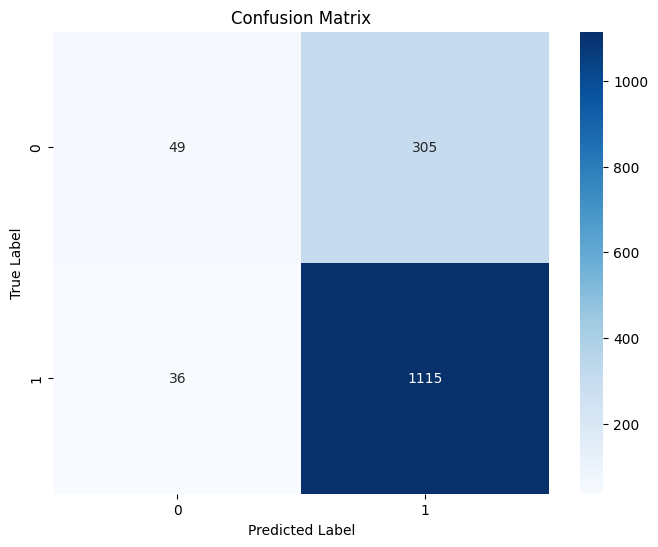

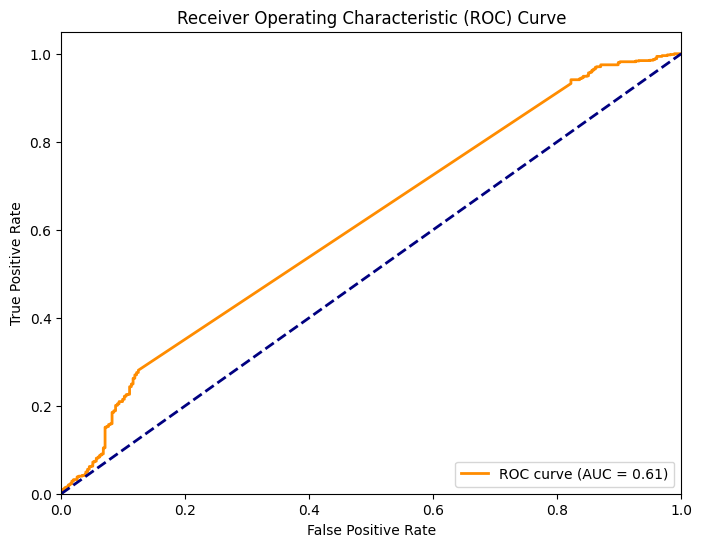

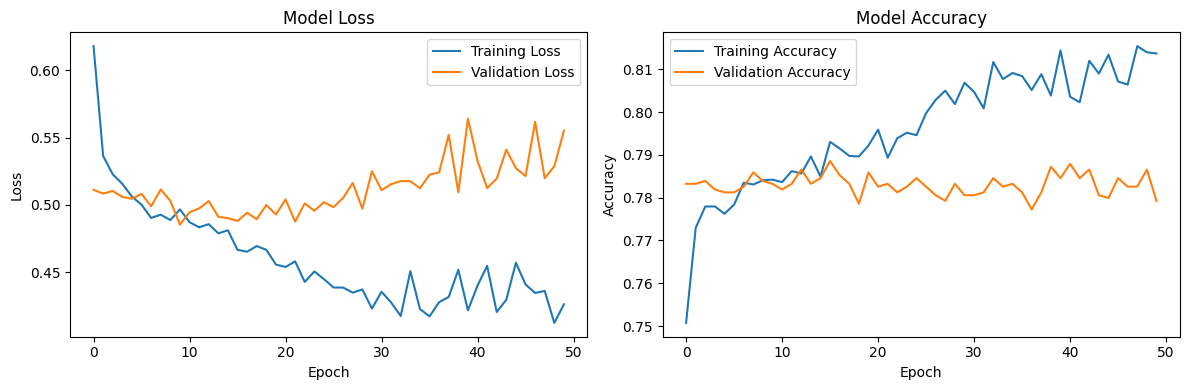

In [19]:
def evaluate_full_classification_model(model, features_dict):
    """
    Comprehensive evaluation of the classification model
    """
    # Prepare test data
    X_test, y_test = features_dict['test']
    y_test_binary = prepare_binary_labels(y_test)
    
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test_binary, y_pred),
        'precision': precision_score(y_test_binary, y_pred),
        'recall': recall_score(y_test_binary, y_pred),
        'f1': f1_score(y_test_binary, y_pred)
    }
    
    # Print metrics
    print("\nFinal Classification Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test_binary, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    metrics['auc'] = roc_auc
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(training_history['loss'], label='Training Loss')
    plt.plot(training_history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(training_history['accuracy'], label='Training Accuracy')
    plt.plot(training_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# Evaluate the model
print("Evaluating full classification model...")
final_metrics = evaluate_full_classification_model(full_model, features_dict)

# Save the final model (optional)
full_model.save('final_classification_model.h5')

# 5. Regression Model

This section implements the Gaussian Process Regression (GPR) model to predict exact LVEF values using the extracted ResNet-50 features.

In [20]:
# Import required libraries
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameters that you can edit
GPR_PARAMS = {
    'kernel_params': {
        'length_scale': [0.1, 0.5, 1.0, 2.0, 5.0],  # Values to try
        'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],         # Values to try
        'noise_level': [1e-4, 1e-3, 1e-2]           # Values to try
    },
    'cv_folds': 5,                # Number of cross-validation folds
    'random_state': 42,           # Random seed
    'n_restarts_optimizer': 5     # Number of restarts for optimization
}

## 5.1 GPR Model Setup
Setting up the Gaussian Process Regression model with Rational Quadratic kernel

In [21]:
def create_gpr_model(length_scale=1.0, alpha=1.0, noise_level=1e-3):
    """
    Create a GPR model with specified kernel parameters
    """
    # Configure kernel
    kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha)
    kernel = kernel + WhiteKernel(noise_level=noise_level)
    
    # Initialize GPR model
    model = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=GPR_PARAMS['n_restarts_optimizer'],
        random_state=GPR_PARAMS['random_state']
    )
    
    return model

def prepare_regression_data(features_dict):
    """
    Prepare data for regression
    """
    # Get data
    X_train, y_train = features_dict['train']
    X_val, y_val = features_dict['val']
    X_test, y_test = features_dict['test']
    
    print("\nRegression Dataset Information:")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    print(f"\nLVEF Range:")
    print(f"Training: {y_train.min():.1f}% - {y_train.max():.1f}%")
    print(f"Mean LVEF: {y_train.mean():.1f}% ± {y_train.std():.1f}%")
    
    return {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }

# Prepare regression data
regression_data = prepare_regression_data(features_dict)


Regression Dataset Information:
Training samples: 7021
Validation samples: 1504
Test samples: 1505

LVEF Range:
Training: 6.9% - 97.0%
Mean LVEF: 55.7% ± 12.4%


## 5.2 Hyperparameter Optimization
Optimizing GPR hyperparameters using cross-validation

In [23]:
def optimize_gpr_hyperparameters(X_train, y_train, params):
    """
    Find optimal hyperparameters using cross-validation
    """
    best_score = float('-inf')
    best_params = None
    
    print("Optimizing hyperparameters...")
    total_combinations = (len(params['kernel_params']['length_scale']) * 
                        len(params['kernel_params']['alpha']) * 
                        len(params['kernel_params']['noise_level']))
    
    for length_scale in params['kernel_params']['length_scale']:
        for alpha in params['kernel_params']['alpha']:
            for noise_level in params['kernel_params']['noise_level']:
                model = create_gpr_model(length_scale, alpha, noise_level)
                
                # Perform cross-validation
                scores = cross_val_score(
                    model, X_train, y_train,
                    cv=params['cv_folds'],
                    scoring='neg_mean_squared_error'
                )
                
                mean_score = scores.mean()
                if mean_score > best_score:
                    best_score = mean_score
                    best_params = {
                        'length_scale': length_scale,
                        'alpha': alpha,
                        'noise_level': noise_level
                    }
    
    print("\nBest parameters found:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Best CV MSE: {-best_score:.4f}")
    
    return best_params

# Find best hyperparameters
X_train, y_train = regression_data['train']
best_params = optimize_gpr_hyperparameters(X_train, y_train, GPR_PARAMS)


Created small sample of 500 instances
Small sample LVEF Range: 14.5% - 82.9%
Small sample Mean LVEF: 55.8% ± 12.4%


/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The opt


Best parameters found:
kernel__k2__noise_level: 0.0001
kernel__k1__length_scale: 0.1
kernel__k1__alpha: 0.1
Best CV MSE: 2598.4316


/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
